This notebook is for preparation data before an analysis

In [1]:
import numpy as np
import pandas as pd
import cooler
from cooltools.api.sample import sample
from cooltools.api.insulation import calculate_insulation_score
from cooltools.api.eigdecomp import eigs_cis
import bioframe

from matplotlib import pyplot as plt
import seaborn as sns

from glob import glob
from tqdm.notebook import tqdm
from natsort import natsorted
from os.path import basename, splitext
import os

# Hi-C

In [6]:
#paths
COOLER_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC'
DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/downsampled'
INSULATION_PATH = '/tank/projects/kriukov_chromatin/HIC/insulation'
COMPARTMENTS_PATH = '/tank/projects/kriukov_chromatin/HIC/compartments'
GENOME_FOLDER_PATH = '/tank/projects/kriukov_chromatin/GENOME'

RESOLUTION = 50000
#FILES = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))
FILES = natsorted(glob('%s/merged/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))
#FILES = natsorted(glob('%s/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))

#CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
CLRS = [cooler.Cooler(p) for p in FILES]
LABELS = [os.path.basename(p).split('.')[0] for p in FILES]

In [10]:
#downsampling procedure
if not os.path.exists(DOWNSAMPLED_FOLDER_PATH):
    os.makedirs(DOWNSAMPLED_FOLDER_PATH)

RESOLUTION = 25_000
MIN_SUM = min([c.info['sum'] for c in CLRS])
for l, c in zip(LABELS, CLRS):
    sample(c, '%s/%s_down_%d.cool' % (DOWNSAMPLED_FOLDER_PATH, l, RESOLUTION), 
                  count=MIN_SUM//1000*1000, 
                  exact=False,
                  chunksize=100_000_000)

INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_female_2_down_25000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/cooler/core.py:123: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif is_categorical(data):
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_female_3_down_25000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Creating cooler at "/tank/projects/kriukov_chromatin/HIC/downsampled/KO_male_1_down_25000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:coole

In [4]:
#insulation scores
if not os.path.exists(INSULATION_PATH):
    os.makedirs(INSULATION_PATH)

df = pd.DataFrame()
for l, c in zip(LABELS, CLRS):
    IS = calculate_insulation_score(c, 
                                    window_bp=[RESOLUTION * 10], 
                                    ignore_diags=2, 
                                    append_raw_scores=False)
    df[l] = np.array(IS.filter(regex=("log2*"))).squeeze()


##additional masking around NaN
binstatus = pd.DataFrame({basename(c.filename):c.bins()[:]['weight'] for c in CLRS})

k = 11 #left and right around nan will be nan to avoid `edge effect`
N = df.shape[0]
nanids = binstatus[binstatus.isna().any(1)].index.tolist()
for i in nanids:
    l = i - k if i - k >=0 else 0
    r = i + k if i + k < N else N
    df.iloc[l:r] = np.nan

#postprocessing
IS_info = IS[['chrom', 'start', 'end']].reset_index()
IS_info['index'] = IS_info['index'].apply(str
                                         )
df = df.reset_index()
df['index'] = df['index'].apply(str)
df = df.merge(IS_info, on='index')
df.to_csv('%s/IS_%s.csv' % (INSULATION_PATH, RESOLUTION))
#df.to_csv('%s/IS_merged_%s.csv' % (INSULATION_PATH, RESOLUTION))

In [10]:
#compartments
if not os.path.exists(COMPARTMENTS_PATH):
    os.makedirs(COMPARTMENTS_PATH)

mm10 = bioframe.fetch_chromsizes('mm10')
chromsizes = bioframe.fetch_chromsizes('mm10')
chromosomes = list(chromsizes.index)

In [11]:
bins = cooler.binnify(mm10, binsize=RESOLUTION)
fasta_records = bioframe.load_fasta('%s/GCF_000001635.27_GRCm39_genomic.fna' % GENOME_FOLDER_PATH)

###CONVERT REFSEQ to CHROMNAMES
fasta_annot = pd.read_csv('%s/GCF_000001635.27_GRCm39_assembly_report.txt' % GENOME_FOLDER_PATH, sep='\t', skiprows=28)
fasta_annot = fasta_annot[fasta_annot['Sequence-Role']=='assembled-molecule']
fasta_keys = fasta_annot[['Assigned-Molecule', 'RefSeq-Accn']].set_index('RefSeq-Accn')
filt_keys = fasta_keys.loc[list(set(list(fasta_records.keys())).intersection(fasta_keys.index))].to_dict()
new_dict = {}
for key, item in fasta_records.items():
    if key in filt_keys['Assigned-Molecule'].keys():
        nk = 'chr' + filt_keys['Assigned-Molecule'][key]
        nk = 'chrM' if nk == 'chrMT' else nk
        new_dict[nk] = item
        
gc = bioframe.frac_gc(bins, new_dict)

#######
bins['GC'] = gc['GC']
bins = bins.drop(bins[bins.chrom=='chrM'].index)

##additional masking around NaN
binstatus = pd.DataFrame({basename(c.filename):c.bins()[:]['weight'] for c in CLRS})
mask_indices = binstatus[binstatus.isna().any(1)].index

In [24]:
bins

,chrom,start,end,GC
0,chr1,0,50000,NaN
1,chr1,50000,100000,NaN
2,chr1,100000,150000,NaN
3,chr1,150000,200000,NaN
4,chr1,200000,250000,NaN
...,...,...,...,...
54515,chrY,91500000,91550000,NaN
54516,chrY,91550000,91600000,NaN
54517,chrY,91600000,91650000,NaN
54518,chrY,91650000,91700000,NaN


In [28]:
lam = {}
eigs = {}

for l,c in zip(LABELS, CLRS):
    lam[l], eigs[l] = eigs_cis(
        c,
        phasing_track=bins,
        n_eigs=8,
        bad_bins=mask_indices,
        ignore_diags=2,
        sort_metric='var_explained')

    # Save text files
    lam[l].to_csv(f'{COMPARTMENTS_PATH}/{l}_{RESOLUTION}.cis.lam.txt', sep='\t')
    eigs[l].to_csv(f'{COMPARTMENTS_PATH}/{l}_{RESOLUTION}.cis.vecs.txt', sep='\t', index=False)

In [29]:
!ls /tank/projects/kriukov_chromatin/HIC/compartments

KO_female_2_50000.cis.lam.txt
KO_female_2_50000.cis.vecs.txt
KO_female_3_50000.cis.lam.txt
KO_female_3_50000.cis.vecs.txt
KO_male_1_50000.cis.lam.txt
KO_male_1_50000.cis.vecs.txt
WT_female_2_50000.cis.lam.txt
WT_female_2_50000.cis.vecs.txt
WT_female_3_50000.cis.lam.txt
WT_female_3_50000.cis.vecs.txt
WT_male_1_50000.cis.lam.txt
WT_male_1_50000.cis.vecs.txt
combined_KO_down_50000_50000.cis.lam.txt
combined_KO_down_50000_50000.cis.vecs.txt
combined_WT_down_50000_50000.cis.lam.txt
combined_WT_down_50000_50000.cis.vecs.txt
combined_old_down_50000_50000.cis.lam.txt
combined_old_down_50000_50000.cis.vecs.txt
combined_young_down_50000_50000.cis.lam.txt
combined_young_down_50000_50000.cis.vecs.txt
old_female_2_50000.cis.lam.txt
old_female_2_50000.cis.vecs.txt
old_female_3_50000.cis.lam.txt
old_female_3_50000.cis.vecs.txt
old_male_1_50000.cis.lam.txt
old_male_1_50000.cis.vecs.txt
young_female_2_50000.cis.lam.txt
young_female_2_50000.cis.vecs.txt
young_female_3_50000.cis.lam.txt
young_female_3_50

# ATAC-seq

# RNA-seq

* neural stem cells (NSC), 
* astrocyte-restricted precursors (ARP),
* astrocytes (ASC), 
* oligodendrocyte precursor cells (OPC), 
* oligodendrocytes (OLG), 
* lfactory ensheathing glia (OEG), 
* neuronal-restricted precursors (NRP), 
* immature neurons (ImmN), 
* mature neurons (mNEUR),
* neuroendocrine cells (NendC), 
* ependymocytes (EPC), 
* hypendymal cells (HypEPC), 
* tanycytes (TNC), 
* choroid plexus epithelial cells (CPC), 
* endothelial cells (EC), 
* pericytes (PC), 
* vascular smooth muscle cells (VSMC), 
* hemoglobin-expressing vascular cells (Hb-VC), 
* vascular and leptomeningeal cells (VLMC), 
* arachnoid barrier cells (ABC), 
* microglia (MG), 
* monocytes (MNC), 
* macrophages (MAC), 
* dendritic cells (DC) 
* neutrophils (NEUT)

## pseudobulk DE

In [2]:
rna_list = natsorted(glob('/tank/projects/kriukov_chromatin/RNA/GSE129788/*X.txt'))
genes = pd.read_csv(rna_list[0], '\t').index.tolist()
ann = pd.read_csv('/tank/projects/kriukov_chromatin/RNA/GSE129788/GSE129788_Supplementary_meta_data_Cell_Types_Etc.txt', sep='\t')
ann = ann.drop(0)
ann['ID'] = ann.NAME.apply(lambda x: x.split('data_')[1])
ann['miceID'] = ann.ID.apply(lambda x: x.split('_')[0])
ann['ageID'] = ann['animal_type'] + '_' +ann['miceID']
ann = ann.set_index('ID')

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
ann.cell_classes.value_counts()

OLG_Lin       15463
ASC_Lin        7097
NEURON_Lin     5773
IMMUNE_Lin     4448
VASC_Lin       3884
EPC_Lin         404
Name: cell_classes, dtype: int64

In [4]:
ann.head()

,NAME,nGene,nUMI,cluster,animal_type,cell_classes,cell_type_age,miceID,ageID
ID,,,,,,,,,
6_AAACCTGAGGCCCTTG,Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG,1546,3546,MG,young,IMMUNE_Lin,MG_young,6,young_6
6_AAACGGGAGAGACGAA,Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA,734,1589,MG,young,IMMUNE_Lin,MG_young,6,young_6
6_AAAGTAGCAACGATCT,Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT,456,1129,MG,young,IMMUNE_Lin,MG_young,6,young_6
6_AACCGCGCAACAACCT,Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT,1236,2697,MG,young,IMMUNE_Lin,MG_young,6,young_6
6_AACTCCCAGTACGTAA,Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA,622,1115,MG,young,IMMUNE_Lin,MG_young,6,young_6


In [12]:
print('Cell classes:', ann.cell_classes.unique(), '\n')
print('Cell types:\n', ann.cell_type_age.unique())

Cell classes: ['IMMUNE_Lin' 'OLG_Lin' 'NEURON_Lin' 'VASC_Lin' 'ASC_Lin' 'EPC_Lin'] 

Cell types:
 ['MG_young' 'MG_old' 'NEUT_young' 'NEUT_old' 'DC_old' 'DC_young' 'MAC_old'
 'MAC_young' 'OLG_young' 'OLG_old' 'OPC_young' 'OPC_old' 'OEG_young'
 'OEG_old' 'mNEUR_young' 'mNEUR_old' 'NendC_young' 'NendC_old'
 'ImmN_young' 'ImmN_old' 'ABC_young' 'ABC_old' 'VLMC_young' 'VLMC_old'
 'EC_young' 'EC_old' 'VSMC_young' 'VSMC_old' 'ASC_young' 'ASC_old'
 'NSC_young' 'NSC_old' 'ARP_old' 'ARP_young' 'NRP_young' 'NRP_old'
 'PC_young' 'PC_old' 'Hb_VC_young' 'Hb_VC_old' 'CPC_young' 'CPC_old'
 'TNC_young' 'TNC_old' 'EPC_young' 'EPC_old' 'HypEPC_young' 'HypEPC_old'
 'MNC_young' 'MNC_old']


In [15]:
bycellclass = False

if bycellclass:
    class_type = 'NEURON_Lin'
    target_ann = ann[ann.cell_classes == class_type]
else:
    cell_type_age = ['mNEUR_young', 'mNEUR_old']
    target_ann = ann[ann.cell_type_age.isin(['mNEUR_young', 'mNEUR_old'])]

ids = target_ann.index.tolist()
rna_count = pd.DataFrame(index=genes)
for rna_path in rna_list:
    rna = pd.read_csv(rna_path, '\t')
    intsec = rna.columns.intersection(ids)
    umi = np.asarray(ann.loc[intsec, 'nUMI']).astype(float)
    rna_count = rna_count.merge((np.exp(rna[intsec]) - 1).mul(umi, axis=1) / 10000, 
                                left_index=True, right_index=True)
    

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
df = rna_count.T.copy()

In [21]:
#group by age
bulk = df.groupby(target_ann.loc[df.index]['ageID'].tolist()).sum()

In [23]:
test = bulk.T.copy()

In [24]:
test = test.astype(int)

In [25]:
test.to_csv('/tank/projects/kriukov_chromatin/RNA/GSE129788/pseudoBulk_counts_mature_Neurons.csv')

<AxesSubplot:ylabel='Density'>

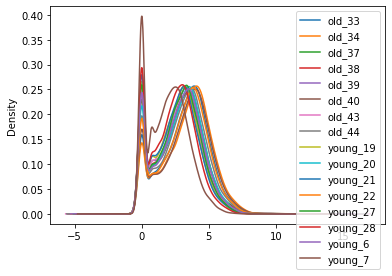

In [26]:
np.log(test+1).plot(kind='kde')

## single-cell DE

In [2]:
import scanpy as sc

In [27]:
rna_list = natsorted(glob('/tank/projects/kriukov_chromatin/RNA/GSE129788/*X.txt'))
genes = pd.read_csv(rna_list[0], '\t').index.tolist()
ann = pd.read_csv('/tank/projects/kriukov_chromatin/RNA/GSE129788/GSE129788_Supplementary_meta_data_Cell_Types_Etc.txt', sep='\t')
ann = ann.drop(0)
ann['ID'] = ann.NAME.apply(lambda x: x.split('data_')[1])
ann['miceID'] = ann.ID.apply(lambda x: x.split('_')[0])
ann['ageID'] = ann['animal_type'] + '_' +ann['miceID']
ann = ann.set_index('ID')

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [79]:


res = pd.concat([pd.read_csv(rna_path, sep='\t') for rna_path in rna_list], axis=1) #open and merge datasets
X = res.T
var = pd.DataFrame(X.columns).set_index(0)
var['symbol'] = X.columns

In [100]:
anndata = sc.AnnData(X=X, obs=ann.loc[X.index], dtype=float)

In [101]:
anndata.write(filename='/tank/projects/kriukov_chromatin/RNA/GSE129788_scrna.h5ad')

... storing 'nGene' as categorical
... storing 'nUMI' as categorical
... storing 'cluster' as categorical
... storing 'animal_type' as categorical
... storing 'cell_classes' as categorical
... storing 'cell_type_age' as categorical
... storing 'miceID' as categorical
... storing 'ageID' as categorical


In [3]:
anndata = sc.read_h5ad('/tank/projects/kriukov_chromatin/RNA/GSE129788_scrna.h5ad')

In [4]:
#below DE analysis with diffxpy
import diffxpy.api as de

2022-07-14 12:27:38.032249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-14 12:27:38.173037: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-14 12:27:38.179379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-14 12:27:38.179399: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [5]:
anndata.obs.columns

Index(['NAME', 'nGene', 'nUMI', 'cluster', 'animal_type', 'cell_classes',
       'cell_type_age', 'miceID', 'ageID'],
      dtype='object')

In [6]:

#cross = [x + '_' + y for x,y in zip(anndata.obs['animal_type'].tolist(), anndata.obs['miceID'].tolist())]
#anndata.obs['age_miceID'] = cross

subset = anndata.obs[anndata.obs['cell_type_age'].isin(['mNEUR_young', 'mNEUR_old'])].index
annsub = anndata[subset, :]

In [7]:
annsub.obs.miceID.value_counts()

40    513
44    435
33    404
34    387
43    367
39    355
38    344
22    342
6     305
20    294
27    291
37    282
19    242
21    235
28    218
7     121
Name: miceID, dtype: int64

In [8]:
annsub.obs

,NAME,nGene,nUMI,cluster,animal_type,cell_classes,cell_type_age,miceID,ageID
6_AAACCTGTCACGCGGT,Aging_mouse_brain_portal_data_6_AAACCTGTCACGCGGT,2792,5951,mNEUR,young,NEURON_Lin,mNEUR_young,6,young_6
6_AACCATGAGACAGAGA,Aging_mouse_brain_portal_data_6_AACCATGAGACAGAGA,2605,6082,mNEUR,young,NEURON_Lin,mNEUR_young,6,young_6
6_AACCATGTCCTTGGTC,Aging_mouse_brain_portal_data_6_AACCATGTCCTTGGTC,636,947,mNEUR,young,NEURON_Lin,mNEUR_young,6,young_6
6_AACTCTTAGGATGTAT,Aging_mouse_brain_portal_data_6_AACTCTTAGGATGTAT,1339,2274,mNEUR,young,NEURON_Lin,mNEUR_young,6,young_6
6_AACTGGTTCCGTCAAA,Aging_mouse_brain_portal_data_6_AACTGGTTCCGTCAAA,3219,7182,mNEUR,young,NEURON_Lin,mNEUR_young,6,young_6
...,...,...,...,...,...,...,...,...,...
44_GGACGTCAGTCCATAC,Aging_mouse_brain_portal_data_44_GGACGTCAGTCCATAC,659,1133,mNEUR,old,NEURON_Lin,mNEUR_old,44,old_44
44_GTAACGTAGAGGTTGC,Aging_mouse_brain_portal_data_44_GTAACGTAGAGGTTGC,938,1472,mNEUR,old,NEURON_Lin,mNEUR_old,44,old_44
44_GTTTCTAAGCAGACTG,Aging_mouse_brain_portal_data_44_GTTTCTAAGCAGACTG,968,1502,mNEUR,old,NEURON_Lin,mNEUR_old,44,old_44
44_TCAACGATCCAGAAGG,Aging_mouse_brain_portal_data_44_TCAACGATCCAGAAGG,1242,2066,mNEUR,old,NEURON_Lin,mNEUR_old,44,old_44


In [69]:
# import patsy
# pat = patsy.dmatrix(formula_like="~ 1 + animal_type + miceID", data=anndata.obs, return_type='dataframe')
# pat.shape
# np.linalg.matrix_rank(pat)

In [18]:
de.utils.preview_coef_names(
    sample_description=anndata.obs,
    formula="~ 1 + animal_type"
)

['Intercept', 'animal_type[T.young]']

In [ ]:
# test = de.test.wald(
#     data=annsub,
#     formula_loc="~1 + animal_type",
#     factor_loc_totest="animal_type",
# )

In [43]:
test_2s = de.test.two_sample(
    data=annsub, 
    grouping="animal_type",
    test="t_test"
)

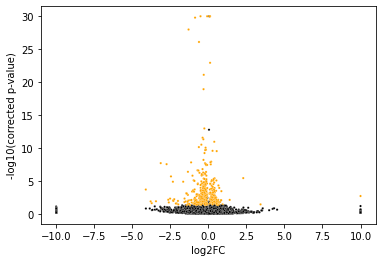

In [47]:
test_2s.summary().sort_values('log2fc')
test_2s.plot_volcano(corrected_pval=True, min_fc=1.05, alpha=0.05, size=5)

In [48]:
res = test_2s.summary()

In [49]:
dr = res[(res.log2fc < 0)].sort_values('pval').gene[:10].values.tolist()
ur = res[(res.log2fc > 0)].sort_values('pval').gene[:10].values.tolist()
top = ur + dr

In [50]:
res[res.gene=='Pisd']

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
4375,Pisd,0.002124,0.043515,-0.248037,0.352176,False,False


In [54]:
res

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
0,Sox17,2.349176e-01,5.914318e-01,-1.323657,0.002042,False,False
1,Mrpl15,1.006543e-01,4.118609e-01,-0.183247,0.189106,False,False
2,Lypla1,2.876536e-01,6.493459e-01,-0.150355,0.118566,False,False
3,Tcea1,1.239994e-02,1.349966e-01,-0.247740,0.237608,False,False
4,Rgs20,6.180311e-03,8.712790e-02,0.458945,0.084375,False,False
...,...,...,...,...,...,...,...
14694,mt-Cytb,1.961433e-60,9.438414e-57,0.089686,4.701615,False,False
14695,Vamp7,9.824077e-02,4.075327e-01,-0.198812,0.161234,False,False
14696,AC168977.1,1.675183e-02,1.606818e-01,-1065.438419,0.001591,False,False
14697,PISD,2.927701e-41,5.283037e-38,-0.514795,1.189392,False,False


In [51]:
res.to_csv('subdata/scDE_results_GSE129788_old::young.csv')

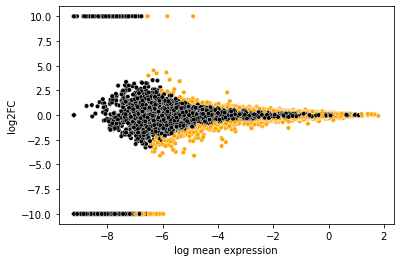

In [53]:
test_2s.plot_ma()